#**Implémentez un modèle de scoring**

**Les tables et relations**

Nous disposons 07 importantes tables données comme l'illustre le schéma ci-dessous :

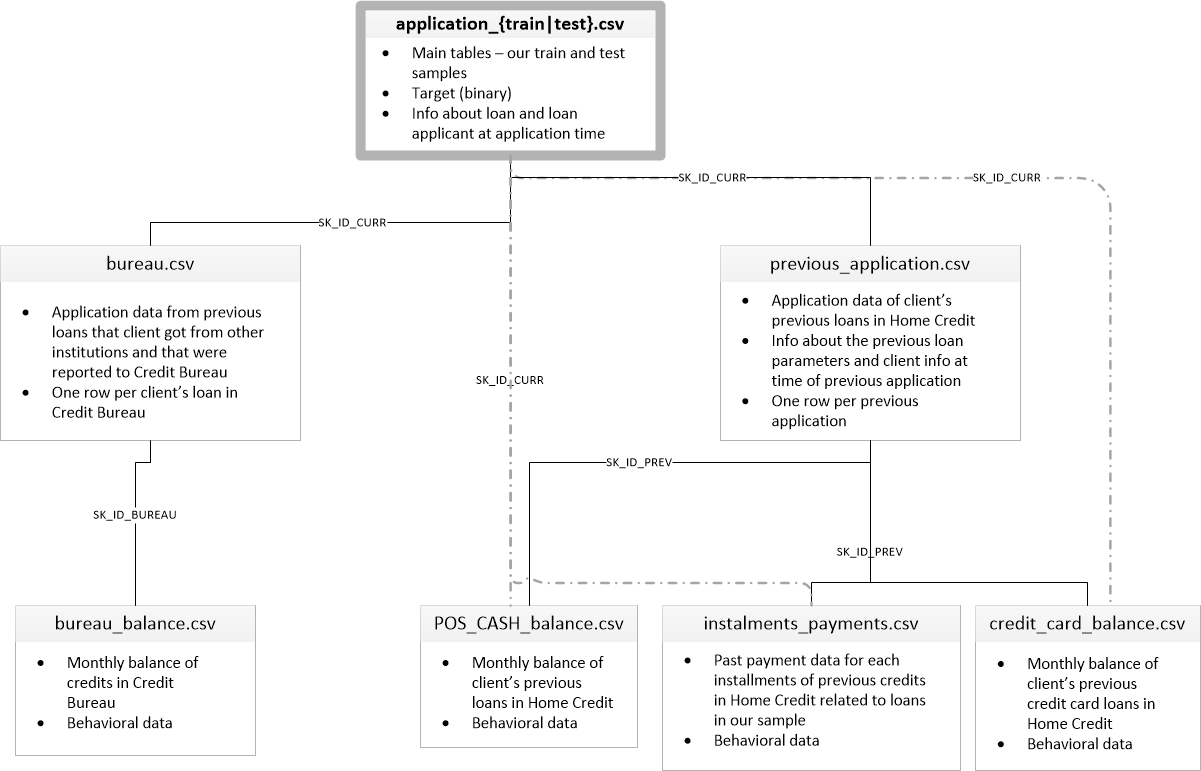

**Bibliotéques nécessaires**

In [ ]:
# Pour la manipulation
import numpy as np
import pandas as pd
# Pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, OneHotEncoder # Encodage des variables catégorielles
from sklearn.impute import SimpleImputer # Gérer les NaNs
from sklearn.model_selection import KFold  # Pour diviser le dataset en plis
from sklearn.metrics import roc_auc_score # évaluation des modèles

import lightgbm as lgb

import gc  # Pour libérer la mémoire
import os # Gestion du système de fichiers du drive

# Supprimer les avertissements
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


**Chargement de données**

**Dossier de travail**

In [ ]:
# Connecter à googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Notre répertoire de travail
chemin = r"/content/gdrive/MyDrive/Colab Notebooks/Projet_OPC/P7_Implémentez_modele_Scoring/Data"

# Liste des fichiers ou dossier à l'intérieur
os.listdir(chemin)

['HomeCredit_columns_description.csv',
 'credit_card_balance.csv',
 'bureau_balance.csv',
 'POS_CASH_balance.csv',
 'application_test.csv',
 'bureau.csv',
 'installments_payments.csv',
 'sample_submission.csv',
 'previous_application.csv',
 'application_train.csv',
 'log_reg_baseline.csv',
 'train_bureau.csv',
 'test_bureau.csv',
 'correlations.csv',
 'test_bureau_corrs.csv',
 'train_bureau_corrs.csv']

Nous disposons 10 tables qu'il faudra joindre pour une information complètes sur les clients et leurs conditions de prêts.

In [ ]:
# Choisir le répertoire
dir = os.chdir('/content/gdrive/MyDrive/Colab Notebooks/Projet_OPC/P6_Classification_automatiquement_des_biens/data')

**application_train.csv**
Elle contient les principales informations des clients (âge, revenu, profession, etc.) ayant demandé un crédit.

In [ ]:
# Les données d'entrainement
app_train = pd.read_csv(chemin + '/application_train.csv')
print('Dimension des données: ', app_train.shape)
app_train.head()

Dimension des données:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Les données d'entraînement contiennent **307 511** observations, où chaque observation représente un prêt distinct ayant chacune **122** caractéristiques.
La variable **TARGET** est la cible qu'on cherche à prédire.
  - 0 : le prêt a été remboursé
  - 1 : le prêt n'a pas été remboursé

**Description des variables**

In [ ]:
desc = pd.read_csv(chemin + '/HomeCredit_columns_description.csv', encoding = 'unicode_escape', index_col=0)
desc.head(20)

,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


**Les données test : application_test.csv**

In [ ]:
# Les données test
app_test = pd.read_csv(chemin + '/application_test.csv')
print('Dimension des données: ', app_test.shape)
app_test.head()

Dimension des données:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Elle contient les principales informations, sauf la cible, des clients ayant demandé un crédit.

###**Analyses Exploratoire de Données**

Nous allons dans cette étape calculer des statistiques descriptives et à générer des visualisations afin d'identifier des tendances, des anomalies, des relations ou des schémas au sein des données. L'objectif principal est de comprendre ce que les données peuvent nous révéler.

**Examinons la distribution de la variable cible**

In [ ]:
app_train['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


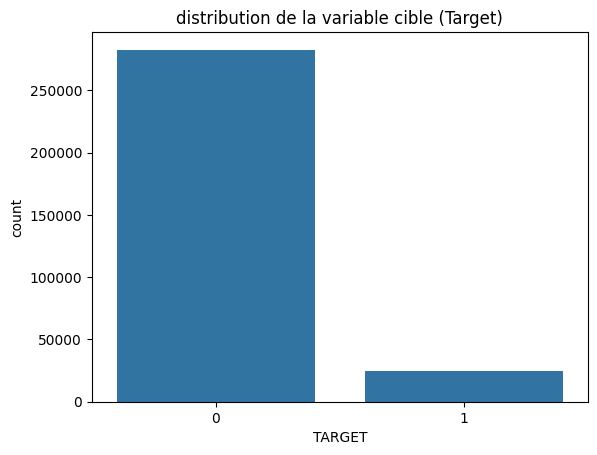

In [ ]:
sns.countplot(x = 'TARGET', data = app_train)
plt.title ("distribution de la variable cible (Target)")
plt.show();

**Problème de classe déséquilibrée** :

Nous avons, ici, un problème de déséquilibre de classes. **Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés.**

**Fonction pour les valeurs manquantes**

In [ ]:
# Fonction pour calculer les valeurs manquantes par colonne
def missing_values_table(df):
        # Total des valeurs manquantes
        mis_val = df.isnull().sum()

        # Pourcentage des valeurs manquantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Créer un tableau avec les résultats
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Renommer les colonnes
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valeurs Manquantes', 1 : '% des Valeurs Totales'})

        # Trier le tableau par pourcentage de valeurs manquantes (ordre décroissant)
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% des Valeurs Totales', ascending=False).round(1)

        # Affichage
        print ("La table contient " + str(df.shape[1]) + " colonnes.\n"
            "Il y a " + str(mis_val_table_ren_columns.shape[0]) +
              " colonnes ayant des valeurs manquantes.")

        # Retourner le dataframe avec les informations sur les valeurs manquantes
        return mis_val_table_ren_columns


In [ ]:
# La statistique des NANS par variables
missing_values = missing_values_table(app_train)
missing_values.head(20)

La table contient 122 colonnes.
Il y a 67 colonnes ayant des valeurs manquantes.


,Valeurs Manquantes,% des Valeurs Totales
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Il sera interêsant de remplacer ces valeurs manquantes avant d'entrainer nos modèles.

####**Les types de colonnes**

In [ ]:
# Le nombre colonne par types
app_train.dtypes.value_counts()

,count
float64,65
int64,41
object,16


Adapter les poids des formats de variables num (8, 32, 64) ?

In [ ]:
# Les modalités des variables catégorielles
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

,0
NAME_CONTRACT_TYPE,2
CODE_GENDER,3
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2
NAME_TYPE_SUITE,7
NAME_INCOME_TYPE,8
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,6
NAME_HOUSING_TYPE,6
OCCUPATION_TYPE,18


La majeure partie des variables a peut de modalités. Passons à leurs encodage

**Encodage des variables**

*Label Encoder*

In [ ]:
# Intencier LabelEncoder
le = LabelEncoder()
# Initialiser un compteur garder une trace du nombre de colonnes ayant été encodées
le_count = 0

# Itérer à travers les colonnes et s'assurer que la variable est de type 'object'
for col in app_train:
    if app_train[col].dtype == 'object':
        # Sur les variables ayant 2 ou moins de modalités
        if len(list(app_train[col].unique())) <= 2:
            # On applique le LabelEncoder sur les données d'entrainement
            le.fit(app_train[col])
            # Transformer les modalités en valeurs numériques
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

            # Incrémente le compteur
            le_count += 1

print('%d variables encodées.' % le_count)

2 variables encodées.


*Encodage avec one-hot encoding*

In [ ]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print("Taille de données d'entrainement: ", app_train.shape)
print("Taille de données de Test: ", app_test.shape)

Taille de données d'entrainement:  (307511, 243)
Taille de données de Test:  (48744, 239)


Il existe plus de varaiables dans la trainset que dans testset. Il faudra les aligner.

*Aligner les données d'entrainement aux données test*

In [ ]:
train_labels = app_train['TARGET']
# Aligner les données d'entraînement et de test, en gardant seulement les colonnes présentes dans les deux df
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Ajouter la cible (TARGET) à nouveau dans les données d'entraînement
app_train['TARGET'] = train_labels

# Afficher la taille des données d'entraînement et de test
print("Taille de données d'entraînement: ", app_train.shape)
print("Taille de données de test: ", app_test.shape)


Taille de données d'entraînement:  (307511, 122)
Taille de données de test:  (48744, 121)


**Les valeurs abérantes**

Ces anomalies, sur les données, peuvent être dues à des erreurs de saisie, à des problèmes avec les équipements de mesure, ou elles peuvent être valides mais représenter des valeurs extrêmes.
Nous examinons les statistiques descriptives de chaque variable pour verifier ces anomalies de manière quantitative.

In [ ]:
app_train['DAYS_BIRTH']

,DAYS_BIRTH
0,-9461
1,-16765
2,-19046
3,-19005
4,-19932
...,...
307506,-9327
307507,-20775
307508,-14966
307509,-11961


Les valeurs dans la colonne **DAYS_BIRTH** sont négatives car elles sont enregistrées par rapport à la date actuelle de la demande de prêt.
Pour avoir ses statitiques descriptives, nous allons le **multiplier par -1** et le **diviser par 365** pour les avoir en années.

In [ ]:
((app_train['DAYS_BIRTH'] / -365)).describe()

,DAYS_BIRTH
count,307511.000000
mean,43.936973
std,11.956133
min,20.517808
25%,34.008219
50%,43.150685
75%,53.923288
max,69.120548


Le problème est maintenant réglé.

Après avoir vérifié les âges et constaté qu'ils sont raisonnables, la prochaine étape consiste à examiner les **jours d'emploi**.

In [ ]:
app_train['DAYS_EMPLOYED'].describe()

,DAYS_EMPLOYED
count,307511.000000
mean,63815.045904
std,141275.766519
min,-17912.000000
25%,-2760.000000
50%,-1213.000000
75%,-289.000000
max,365243.000000


La valeur maximale est **365 243** jours, soit plus 1000 ans !

Voyons la tendence des clients normaux par rapport au clients anormaux.

In [ ]:
# Définir un seuil pour détecter les valeurs anormales
# Par exemple, considérons comme anormaux les clients ayant un nombre de jours d'emploi égal à 365243
anomalous_clients = app_train[app_train['DAYS_EMPLOYED'] == 365243]

# Vérifier le taux de défaut pour les clients anormaux
anomalous_default_rate = anomalous_clients['TARGET'].mean()

# Vérifier le taux de défaut pour les autres clients (non anormaux)
normal_clients = app_train[app_train['DAYS_EMPLOYED'] != 365243]
normal_default_rate = normal_clients['TARGET'].mean()

print(f"Taux de défaut des clients anormaux : {100 * anomalous_default_rate:.2f}")
print(f"Taux de défaut des clients normaux : {100 * normal_default_rate:.2f}")
print("Il  %d jours d'emploi anormaux" % len(anomalous_clients))

Taux de défaut des clients anormaux : 5.40
Taux de défaut des clients normaux : 8.66
Il  55374 jours d'emploi anormaux


Nous allons remplacer les valeurs anormales par des **NANs** et créer une nouvelle colonne booléenne indiquant si la valeur était anormale ou non.

In [ ]:
# Identifier les anomalies dans le dataset
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Remplacer les anomalies par NaN
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

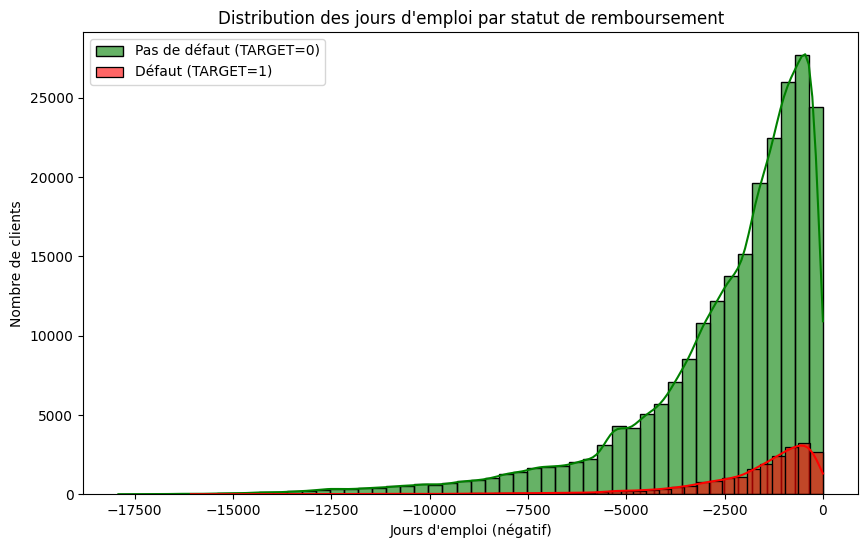

In [ ]:
# Client sans défaut de paiement
employed_no_default = app_train[app_train['TARGET'] == 0]['DAYS_EMPLOYED']
# Client avec défaut de paiement
employed_default = app_train[app_train['TARGET'] == 1]['DAYS_EMPLOYED']

# Tracer les distributions
plt.figure(figsize=(10, 6))
sns.histplot(employed_no_default, bins=50, kde=True, color='green', label='Pas de défaut (TARGET=0)', alpha=0.6)
sns.histplot(employed_default, bins=50, kde=True, color='red', label='Défaut (TARGET=1)', alpha=0.6)

# Ajouter des titres et légendes
plt.title('Distribution des jours d\'emploi par statut de remboursement')
plt.xlabel('Jours d\'emploi (négatif)')
plt.ylabel('Nombre de clients')
plt.legend()
plt.show();

La distribution semble beaucoup plus conforme à ce que nous attendons.
Nous remarquons que **les clients "en défaut de remboursement" ont une durée d'emploi plus courte (proche de 0)**.

Nous faisons le même traitement sur les données test.

In [ ]:
# Identifier les anomalies dans les jours d'emploi pour les données de test
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243

# Remplacer la valeur anormale (365243) par NaN
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# Afficher le nombre d'anomalies détectées dans les données de test
print('Il y a %d anomalies dans les données de test sur un total de %d entrées' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

Il y a 9274 anomalies dans les données de test sur un total de 48744 entrées


**Les corrélations**

Ici, on cherche à trouver les corrélations des variables avec la cible (TARGET)

In [ ]:
# Trouver les corrélations avec la cible (TARGET) et les trier
correlations = app_train.corr()['TARGET'].sort_values()

# Afficher les corrélations
print('Corrélations les plus positives :\n', correlations.tail(15))
print('\nCorrélations les plus négatives :\n', correlations.head(15))

Corrélations les plus positives :
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Corré

**DAYS_BIRTH** et **DAYS_EMPLOYED** sont les plus corrélées à la cible TARGET, respectivement **0.08** et **0.07**

La variable **DAYS_BIRTH** représente l'âge du client en jours négatifs, ce qui peut prêter à confusion. Une corrélation positive avec la cible (TARGET) signifie qu'en vieillissant, les clients sont moins susceptibles de faire défaut de paiement (cible = 0). Pour simplifier, on prendra la valeur absolue de DAYS_BIRTH. Cela inversera la corrélation, qui deviendra négative, rendant le lien entre l'âge et le risque de défaut plus intuitif.

Les variables **EXT_SOURCE_1**, **EXT_SOURCE_2** et **EXT_SOURCE_3** ont les corrélation négatrives les plus importantes.

**Corrélation âge vs le défaut de paiement**

In [ ]:
# Transformer les valeurs en valeurs absolues
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
# Calculer et arrondir la corrélation à 2 décimales
round(app_train['DAYS_BIRTH'].corr(app_train['TARGET']), 2)


-0.08

Cette corrélation de **-0.08** indique **une relation très faible et négative entre DAYS_BIRTH  et TARGET**. Cela signifie que plus un client est âgé, plus il a tendance à rembourser ses prêts à temps (cible = 0).

Pour approfondir cette observation, commençons par explorer la distribution de l'âge des clients.

**Visualisation des relations**

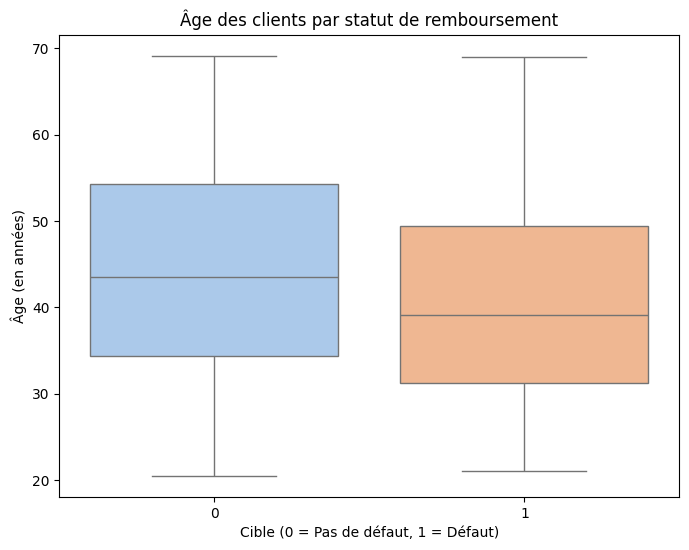

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = app_train['TARGET'], y = app_train['DAYS_BIRTH'] / 365, palette="pastel")
plt.title('Âge des clients par statut de remboursement')
plt.xlabel('Cible (0 = Pas de défaut, 1 = Défaut)')
plt.ylabel('Âge (en années)')
plt.show();

**L'âge moyen des clients ayant remboursé (cible = 0) est plus élevé que celui des clients en défaut (cible = 1)**. Ce qui confirme la relation négative entre l'âge et la probabilité de défaut.

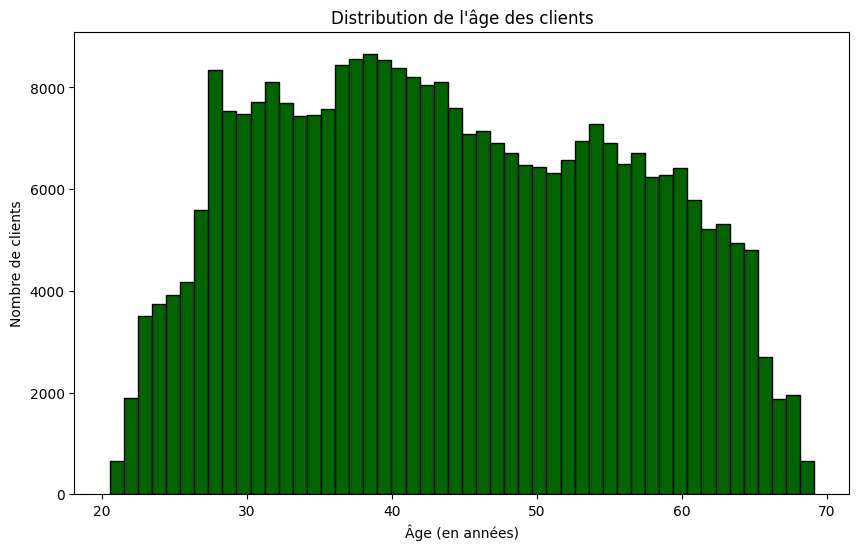

In [ ]:
# Convertir l'âge de jours en années
distbut_client  = app_train.copy()
distbut_client['AGE_YEARS'] = app_train['DAYS_BIRTH'] / 365

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(distbut_client['AGE_YEARS'], bins=50, color='darkgreen', edgecolor='black')
plt.title("Distribution de l'âge des clients")
plt.xlabel('Âge (en années)')
plt.ylabel('Nombre de clients')
plt.show();

On observe que **les clients de plus 25 ans et moins 65 ans sont les plus représentées** dans les données.

 Examinons la proportion moyenne de défaut de paiement (cible = 1) dans différentes tranches d'âge si cela peut révéler des schémas clairs.

L'idée ici est de segmenter l'âge en tranches de 5 ans et de calculer la proportion de prêts non remboursés pour chaque tranche d'âge. Cela nous permet d'analyser si le taux de défaut varie systématiquement en fonction de l'âge.

In [ ]:
# Informations sur l'âge dans un DataFrame séparé
age_data = app_train[['TARGET', 'DAYS_BIRTH']]

# Ajouter une colonne contenant l'âge en années
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Diviser les données d'âge par intervalles de 5 ans
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

# Afficher les 10 premières lignes du DataFrame
age_data.head(10)


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


On regroupe les données par tranches d'âge et calcule les moyennes

In [ ]:
# Regrouper les données par tranches d'âge et calculer les moyennes pour chaque tranche d'âge
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


**Visualisation du défaut de remboursement par tranches d'âges**

In [ ]:
# On réinitialise l'index pour rendre YEARS_BINNED une colonne
age_groups_reset = age_groups.reset_index()
# Convertir les tranches d'âge en chaînes pour les utiliser comme catégories
age_groups_reset['YEARS_BINNED'] = age_groups_reset['YEARS_BINNED'].astype(str)

# Visualisation
fig = px.bar(
    age_groups_reset,
    x='YEARS_BINNED',  # Tranches d'âge
    y='TARGET',        # Moyenne du taux de défaut
    text='TARGET',     # Afficher les valeurs sur les barres
    labels={'TARGET': "Défaut de remboursement (%)', 'YEARS_BINNED': 'Tranche d'âge (années)"},
    title="Défaut de remboursement par tranche d'âge"
)

# Modifier les valeurs pour afficher le pourcentage
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside', marker_color='lightskyblue')
fig.update_yaxes(tickformat=".0%", title_text="Défaut de remboursement (%)")
fig.update_layout(xaxis_title="Tranche d'âge (années)", title_x=0.5)

# Affichage
fig.show();

**Le graph indique que les jeunes sont plus susceptibles de faire défaut par rapport aux tranches d'âge plus âgées.**

Les variables EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3 (notes des institutions de notations comme S&P pour evaluer la fiabilités des particuliers) sont les variables les plus fortement corrélées négativement avec la cible (TARGET).

In [ ]:
# Extraire les variables EXT_SOURCE et afficher les corrélations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# Calculer les corrélations entre les colonnes
ext_data_corrs = ext_data.corr()

# Afficher la matrice de corrélation
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


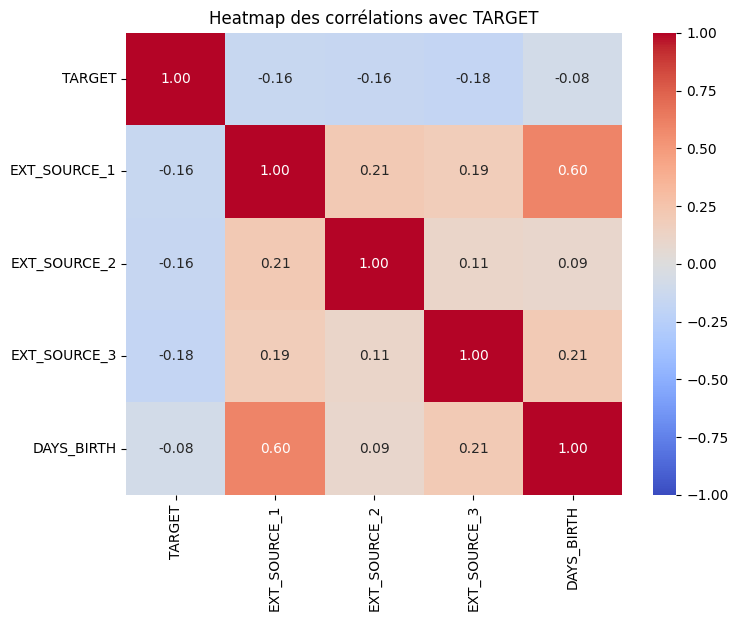

In [ ]:
# La Matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(
    ext_data_corrs,
    annot=True,  # Afficher les coefficients de corrélation
    fmt=".2f",   # Arrondir à 2 décimales
    cmap="coolwarm",  # Palette de couleurs
    vmin=-1, vmax=1   # Échelle des corrélations
)
plt.title('Heatmap des corrélations avec TARGET')
plt.show();

**Points clés :**

- ***Corrélations négatives avec TARGET*** :

  - Les trois variables EXT_SOURCE_1, EXT_SOURCE_2, et EXT_SOURCE_3 sont corrélées négativement avec TARGET.
  - Cela signifie que plus ces notes sont élevées, faible est la probabilité de faire défaut de paiement; donc une meilleure solvabilité du client.

- ***Relation entre EXT_SOURCE_1 et l'âge (DAYS_BIRTH)***:

  - La corrélation positive entre EXT_SOURCE_1 et DAYS_BIRTH (en valeurs absolues, car DAYS_BIRTH est négatif) suggère que l'âge du client pourrait être l'un des facteurs utilisés pour calculer EXT_SOURCE_1.
 - Par exemple, les clients plus âgés, ayant souvent une meilleure stabilité financière, pourraient recevoir un score EXT_SOURCE_1 plus élevé.


Interessons nous à la distribution de ces varaiables en fonction de la variables cible.

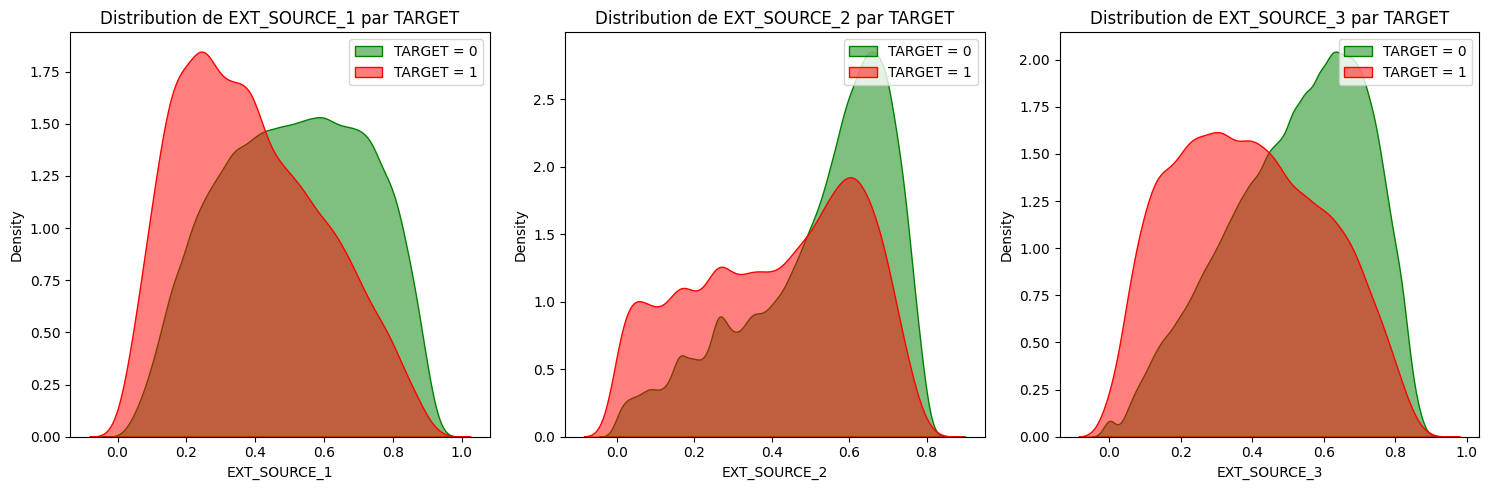

In [ ]:
# Didstribution des trois scores EXT_SOURCE par TARGET
plt.figure(figsize=(15, 5))
for i, col in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    plt.subplot(1, 3, i + 1)
    sns.kdeplot(ext_data.loc[ext_data['TARGET'] == 0, col], label='TARGET = 0', color='green', fill=True, alpha=0.5)
    sns.kdeplot(ext_data.loc[ext_data['TARGET'] == 1, col], label='TARGET = 1', color='red', fill=True, alpha=0.5)
    plt.title(f'Distribution de {col} par TARGET')
    plt.xlabel(col)
    plt.legend()

plt.tight_layout()
plt.show();

Les distributions des notes des autres instutions financières pour TARGET = 0 sont décalées vers des valeurs plus élevées (meilleur score), tandis que celles pour TARGET = 1 sont décalées vers les plus basses. Cela confirme visuellement pourquoi ces variables sont corrélées négativement avec TARGET.

EXT_SOURCE_3 montre la plus grande différence entre les valeur de la variable cible. Cette variable semble bien determinante pour le remboursement du prêt. Ces varaibles pourront utile lors de l'entrainement des modèles.

**Features engineering**

Dans cette partie, nous allons essayer transformer ou combiner les données brutes pour extraire des informations pertinentes (exemple : moyenne des soldes mensuels, nombre de prêts en cours, etc.).
C'est un processus souvent long et fastidieux, qui peut bénéficier d'une expertise dans le domaine des prêts financiers).

En plus de la table ***application_train***, nous allons utiliser les fichiers :    
 - ***bureau*** : qui contient des informations sur les anciens prêts des clients auprès d'autres institutions financières, signalés à Home Credit. Chaque ligne correspond à un prêt.
 - ***bureau_balance*** : qui fournit des informations mensuelles sur les anciens prêts. Chaque ligne correspond à un mois pour un prêt spécifique.

**Fonction d'aggregations**

*Fonction d'aggregation des variables numeriques*

In [ ]:
# Fonction d'aggregation des variables numeriques
def agg_numeric(df, group_var, df_name):
    """
    Agrège les colonnes numériques d'un DataFrame selon une variable de regroupement.
    Permet de créer des nouvelles fonctionnalités pour chaque instance de la variable de regroupement.

    Paramètres
    ----------
    df (dataframe) :
        Le DataFrame contenant les données à agréger.
    group_var (string) :
        La colonne utilisée comme variable de regroupement.
    df_name (string) :
        Préfixe utilisé pour renommer les colonnes après agrégation.

    Retour
    ------
    agg (dataframe) :
        Un DataFrame contenant les statistiques agrégées (count, mean, max, min, sum)
        pour toutes les colonnes numériques. Chaque instance de la variable de regroupement
        aura une ligne avec les nouvelles caractéristiques.
    """
    # Suppression des colonnes d'identifiant autres que la variable de regroupement
    for col in df:
        if col != group_var and 'SK_ID' in col:  # Exemple : "SK_ID_CURR" ou "SK_ID_BUREAU"
            df = df.drop(columns=col)

    # Sauvegarde des identifiants de regroupement
    group_ids = df[group_var]

    # Sélection des colonnes numériques uniquement
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids  # Réintégration de la variable de regroupement

    # Regrouper par la variable spécifiée et calculer les statistiques
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Création de nouveaux noms de colonnes
    columns = [group_var]  # On commence par la colonne de regroupement

    # Parcourir les noms des variables (niveaux supérieurs des colonnes agrégées)
    for var in agg.columns.levels[0]:
        # Ignorer la variable de regroupement
        if var != group_var:
            # Parcourir les noms des statistiques (niveaux inférieurs des colonnes agrégées)
            for stat in agg.columns.levels[1][:-1]:
                # Créer un nouveau nom de colonne combinant le nom du DataFrame, la variable et la statistique
                columns.append(f'{df_name}_{var}_{stat}')

    # Renommer les colonnes du DataFrame agrégé
    agg.columns = columns

    # Retourner le DataFrame agrégé
    return agg

*Fonction d'aggregation des variables qualitatives*

In [ ]:
def count_categorical(df, group_var, df_name):
    """
    Calcule les occurrences et les fréquences normalisées pour chaque catégorie unique
    dans toutes les variables catégorielles du DataFrame.

    Paramètres :
    --------
    df : pandas.DataFrame
        Le DataFrame contenant les données à traiter.

    group_var : string
        La variable utilisée pour regrouper les données (par exemple, un identifiant unique tel que SK_ID_CURR).
        Pour chaque valeur unique de cette variable, le DataFrame final aura une ligne.

    df_name : string
        Une chaîne de caractères ajoutée au début des noms de colonnes pour identifier leur origine.

    Retourne :
    --------
    categorical : pandas.DataFrame
        Un DataFrame contenant les occurrences ("count") et les fréquences normalisées ("count_norm")
        de chaque catégorie unique dans toutes les colonnes catégorielles, avec une ligne par valeur unique de `group_var`.
    """

    # Sélectionner les colonnes catégorielles et créer des variables indicatrices (dummies)
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # S'assurer que la variable de regroupement est incluse dans les colonnes
    categorical[group_var] = df[group_var]

    # Regrouper les données par la variable de regroupement et calculer la somme et la moyenne
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])

    # Créer une liste pour stocker les nouveaux noms de colonnes
    column_names = []

    # Parcourir les colonnes (niveau 0) du DataFrame groupé
    for var in categorical.columns.levels[0]:
        # Parcourir les statistiques calculées (niveau 1 : 'sum' et 'mean')
        for stat in ['sum', 'mean']:
            # Générer un nom de colonne explicite : "df_name_nom_colonne_statistique"
            column_names.append('%s_%s_%s' % (df_name, var, stat))

    # Renommer les colonnes du DataFrame avec les nouveaux noms
    categorical.columns = column_names

    # Retourner le DataFrame final
    return categorical

*Table principale enrichie*

In [ ]:
# La table principale
train = pd.read_csv(chemin + '/application_train.csv')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# La table bureau
bureau = pd.read_csv(chemin +'/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:
# La table balance_bureau
bureau_balance = pd.read_csv(chemin + '/bureau_balance.csv')
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


**Le nombre bureau par client:**

In [ ]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_sum,bureau_CREDIT_ACTIVE_Active_mean,bureau_CREDIT_ACTIVE_Bad debt_sum,bureau_CREDIT_ACTIVE_Bad debt_mean,bureau_CREDIT_ACTIVE_Closed_sum,bureau_CREDIT_ACTIVE_Closed_mean,bureau_CREDIT_ACTIVE_Sold_sum,bureau_CREDIT_ACTIVE_Sold_mean,bureau_CREDIT_CURRENCY_currency 1_sum,bureau_CREDIT_CURRENCY_currency 1_mean,...,bureau_CREDIT_TYPE_Microloan_sum,bureau_CREDIT_TYPE_Microloan_mean,bureau_CREDIT_TYPE_Mobile operator loan_sum,bureau_CREDIT_TYPE_Mobile operator loan_mean,bureau_CREDIT_TYPE_Mortgage_sum,bureau_CREDIT_TYPE_Mortgage_mean,bureau_CREDIT_TYPE_Real estate loan_sum,bureau_CREDIT_TYPE_Real estate loan_mean,bureau_CREDIT_TYPE_Unknown type of loan_sum,bureau_CREDIT_TYPE_Unknown type of loan_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


**Nouvelles variables à partir des colonnes numériques:**

 - Les variables numériques dans ***bureau*** contiennent des informations importantes sur les prêts précédents des clients.

 - Ces informations sont relationnelles : plusieurs lignes dans bureau correspondent à un même client dans ***application_train***.
 - En calculant des statistiques globales (moyenne, minimum, maximum, somme, etc.) pour chaque client, on peut condenser cette information en une seule ligne par client.

In [ ]:
# Informations sur les crédits précédents par client
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


**Le nombre de prêts par catégorie(*STATUS*)**

In [ ]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_sum,bureau_balance_STATUS_0_mean,bureau_balance_STATUS_1_sum,bureau_balance_STATUS_1_mean,bureau_balance_STATUS_2_sum,bureau_balance_STATUS_2_mean,bureau_balance_STATUS_3_sum,bureau_balance_STATUS_3_mean,bureau_balance_STATUS_4_sum,bureau_balance_STATUS_4_mean,bureau_balance_STATUS_5_sum,bureau_balance_STATUS_5_mean,bureau_balance_STATUS_C_sum,bureau_balance_STATUS_C_mean,bureau_balance_STATUS_X_sum,bureau_balance_STATUS_X_mean
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


**Les statistques de 'bureau_balance' par identifiant de crédit (*SK_ID_BUREAU*)**

In [ ]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


**Agrégation des données mensuelles par prêt et par client :**

On fusionne les statistiques des prêts avec le compte des prêts (par SK_ID_BUREAU)

In [ ]:
# On effectue une fusion externe pour conserver tous les prêts
bureau_by_loan = bureau_balance_agg.merge(
    bureau_balance_counts,           # Données agrégées (statistiques) par prêt
    right_index=True,                # Utilisation de l'index comme clé dans bureau_balance_counts
    left_on='SK_ID_BUREAU',          # Utilisation de la colonne SK_ID_BUREAU comme clé
    how='outer'                      # Fusion externe pour conserver toutes les lignes
)

# Ajouter l'identifiant client (SK_ID_CURR) à chaque prêt
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(
    bureau_by_loan,                  # Données agrégées par prêt
    on='SK_ID_BUREAU',               # Fusion basée sur SK_ID_BUREAU
    how='left'                       # Conserver toutes les lignes de bureau
)

# Agréger les statistiques pour chaque client (par SK_ID_CURR)
# On regroupe par identifiant client et calcule des statistiques agrégées (moyenne, min, max, etc.)
bureau_balance_by_client = agg_numeric(
    bureau_by_loan.drop(columns=['SK_ID_BUREAU']), # Supprimer l'identifiant du prêt car non nécessaire pour l'agrégation
    group_var='SK_ID_CURR',                        # Regroupement par identifiant client
    df_name='client'                               # Préfixe pour les colonnes agrégées
)

# Afficher les premières lignes du DataFrame final pour vérifier le résultat
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_sum_count,client_bureau_balance_STATUS_X_sum_mean,client_bureau_balance_STATUS_X_sum_max,client_bureau_balance_STATUS_X_sum_min,client_bureau_balance_STATUS_X_sum_sum,client_bureau_balance_STATUS_X_mean_count,client_bureau_balance_STATUS_X_mean_mean,client_bureau_balance_STATUS_X_mean_max,client_bureau_balance_STATUS_X_mean_min,client_bureau_balance_STATUS_X_mean_sum
0,100001,7,24.571429,52.0,2.0,172.0,7,-11.785714,-0.5,-25.5,...,7,4.285714,9.0,0.0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002,8,13.750000,22.0,4.0,110.0,8,-21.875000,-1.5,-39.5,...,8,1.875000,3.0,0.0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100003,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,...,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.000000
3,100004,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,...,0,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,0.000000
4,100005,3,7.000000,13.0,3.0,21.0,3,-3.000000,-1.0,-6.0,...,3,0.666667,1.0,0.0,2.0,3,0.136752,0.333333,0.0,0.410256


**On rajoute ces information à la table principale.**

L'objectif est d'enrichir les données avec les informations supplémentaires issues des fichiers ***bureau*** et ***bureau_balance***.

In [ ]:
# Fusionner le jeu d'entraînement avec les comptages des prêts (bureau_counts)
# Les comptages indiquent combien de prêts sont associés à chaque client
train = train.merge(
    bureau_counts,                  # Comptages des prêts par client (SK_ID_CURR)
    on='SK_ID_CURR',                # Fusion sur l'identifiant client
    how='left'                      # Inclure tous les clients même s'ils n'ont pas de prêts
)

# Fusionner le jeu d'entraînement avec les statistiques agrégées des prêts (bureau_agg)
# Ces statistiques incluent les moyennes, minimums, maximums, etc. calculés sur les données des prêts
train = train.merge(
    bureau_agg,                     # Données agrégées par client à partir des prêts
    on='SK_ID_CURR',                # Fusion sur l'identifiant client
    how='left'                      # Inclure tous les clients même si aucune statistique n'existe
)

# Fusionner le jeu d'entraînement avec les informations mensuelles agrégées par client (bureau_balance_by_client)
# Ces informations proviennent du fichier bureau_balance (solde mensuel des prêts)
train = train.merge(
    bureau_balance_by_client,       # Données agrégées par client à partir des informations mensuelles
    on='SK_ID_CURR',                # Fusion sur l'identifiant client
    how='left'                      # Inclure tous les clients même si aucune donnée mensuelle n'existe
)

train.shape

(307511, 333)

*Fonction de traitement des NaNs*

In [ ]:
# Fonction pour calculer les valeurs manquantes par colonne
def missing_values_table(df):
    """
    Cette fonction identifie les colonnes avec des valeurs manquantes dans un DataFrame
    et affiche une table résumant les informations sur ces valeurs.

    Arguments :
    df -- DataFrame (pandas.DataFrame) à analyser.

    Retourne :
    Un DataFrame contenant :
        - Nombre total de valeurs manquantes par colonne
        - Pourcentage de valeurs manquantes par colonne
    """

    # Calculer le nombre total de valeurs manquantes par colonne
    mis_val = df.isnull().sum()

    # Calculer le pourcentage de valeurs manquantes par colonne
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Créer un tableau contenant ces informations
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Renommer les colonnes pour plus de clarté
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0: 'Missing Values', 1: '% of Total Values'}
    )

    # Filtrer pour conserver uniquement les colonnes ayant des valeurs manquantes
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0  # Garder uniquement les colonnes avec valeurs manquantes
    ].sort_values(
        '% of Total Values', ascending=False  # Trier par ordre décroissant
    ).round(1)  # Arrondir les pourcentages à 1 décimale

    # Afficher un résumé des résultats
    print("Votre DataFrame sélectionné contient " + str(df.shape[1]) + " colonnes.\n"
          "Il y a " + str(mis_val_table_ren_columns.shape[0]) +
          " colonnes avec des valeurs manquantes.")
    return mis_val_table_ren_columns


In [ ]:
# Appliquer sur la table train
missing_train = missing_values_table(train)
missing_train.head(10)

Votre DataFrame sélectionné contient 333 colonnes.
Il y a 278 colonnes avec des valeurs manquantes.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_sum_min,215280,70.0
client_bureau_balance_STATUS_3_mean_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_sum_max,215280,70.0
client_bureau_balance_STATUS_4_sum_mean,215280,70.0
client_bureau_balance_STATUS_3_mean_min,215280,70.0
client_bureau_balance_STATUS_3_mean_max,215280,70.0


*Les variables avec plus 90% de valeurs manquantes*

In [ ]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

**On fait de même pour les données test en l'enrichisant avec les des tables bureau et bureau_balance**

In [ ]:
test = pd.read_csv(chemin + '/application_test.csv')

test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
test.shape

(48744, 332)

**Alinger la table train et test**

In [ ]:
train_labels = train['TARGET']

train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (307511, 333)
Testing Features shape:  (48744, 332)


**Les NaNs de la table test**

In [ ]:
missing_test = missing_values_table(test)
missing_test.head(10)

Votre DataFrame sélectionné contient 332 colonnes.
Il y a 275 colonnes avec des valeurs manquantes.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [ ]:
# Sélectionner les colonnes ayant plus de 90% de valeurs manquantes dans les données d'entraînement
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])

# Sélectionner les colonnes ayant plus de 90% de valeurs manquantes dans les données de test
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])

# Combiner les colonnes manquantes des données d'entraînement et de test
# Utilisation de set() pour supprimer les doublons
missing_columns = list(set(missing_test_vars + missing_train_vars))

# Afficher le nombre total de colonnes ayant plus de 90% de valeurs manquantes dans les deux jeux de données
print('Il y a %d colonnes avec plus de 90%% de valeurs manquantes dans les données d\'entraînement ou de test.' % len(missing_columns))


Il y a 0 colonnes avec plus de 90% de valeurs manquantes dans les données d'entraînement ou de test.


**On supprime les nans dans les tables puis les sauvegarder**

In [ ]:
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

In [ ]:
# Sauvegader les tables
train.to_csv('train_bureau.csv', index = False)
test.to_csv('test_bureau.csv', index = False)

In [ ]:
# train = pd.read_csv(chemin + '/train_bureau.csv')
# train

In [ ]:
# test = pd.read_csv(chemin + '/test_bureau.csv')
# test

**Corrélation avec TARGET**

In [ ]:
# Calculer les corrélations avec TARGET pour les variables numériques
corrs = train.select_dtypes('number').corr(method='spearman')['TARGET'].sort_values(ascending=False)
corrs = pd.DataFrame(corrs).rename(columns={'TARGET': 'correlations'})

In [ ]:
corrs.to_csv('correlations.csv', index=True)

In [ ]:
# Les plus corrélées positivement
corrs.head(10)

,correlations
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.095296
client_bureau_balance_MONTHS_BALANCE_min_mean,0.094609
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.092904
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.083568
bureau_DAYS_CREDIT_UPDATE_mean,0.082622
DAYS_BIRTH,0.078328
bureau_CREDIT_ACTIVE_Active_mean,0.078134
client_bureau_balance_MONTHS_BALANCE_sum_min,0.076212
bureau_DAYS_CREDIT_max,0.074270


In [ ]:
# Les plus corrélées négativement
corrs.tail(10)

,correlations
client_bureau_balance_STATUS_C_mean_mean,-0.057091
client_bureau_balance_STATUS_C_sum_max,-0.062233
client_bureau_balance_MONTHS_BALANCE_count_max,-0.071131
client_bureau_balance_MONTHS_BALANCE_count_min,-0.071257
client_bureau_balance_STATUS_C_sum_mean,-0.071418
bureau_CREDIT_ACTIVE_Closed_mean,-0.080127
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.090190
EXT_SOURCE_2,-0.147332
EXT_SOURCE_1,-0.151128
EXT_SOURCE_3,-0.166330


**Variables significatifs**

*Variables numériques*

In [ ]:
# Filtrer les variables ayant une corrélation au-dessus de 0.07
significant_corrs = corrs[abs(corrs) > 0.07]
significant_corrs = pd.DataFrame(significant_corrs['correlations'].dropna()).sort_values("correlations", ascending = False)

*Variabless qualitatives*

In [ ]:
from sklearn.feature_selection import chi2

categorical_vars = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']  # Liste des variables catégorielles

# Encoder les variables
label_encoded = train[categorical_vars].apply(LabelEncoder().fit_transform)

# Test de Chi²
chi_scores, p_values = chi2(label_encoded, train['TARGET'])


In [ ]:
df_results = pd.DataFrame({
    'variable': categorical_vars,
    'chi_scores': chi_scores.round(3),
    'p_values': p_values.round(4)
})
df_results.sort_values('p_values')

,variable,chi_scores,p_values
0,NAME_CONTRACT_TYPE,265.588,0.0000
1,CODE_GENDER,605.629,0.0000
2,FLAG_OWN_CAR,96.889,0.0000
5,NAME_INCOME_TYPE,934.904,0.0000
6,NAME_EDUCATION_TYPE,486.754,0.0000
8,NAME_HOUSING_TYPE,256.451,0.0000
9,OCCUPATION_TYPE,376.258,0.0000
11,ORGANIZATION_TYPE,4138.607,0.0000
12,FONDKAPREMONT_MODE,69.153,0.0000
13,HOUSETYPE_MODE,731.103,0.0000


**On conserve les variables avec un p-value significatif (< 0.05)**

In [ ]:
significant_categorical = df_results[df_results['p_values'] < 0.05].variable.tolist()
print(significant_categorical)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [ ]:
train_significatif = pd.concat([train[significant_corrs.index], train[significant_categorical]], axis = 1)
train_significatif

,TARGET,bureau_DAYS_CREDIT_mean,client_bureau_balance_MONTHS_BALANCE_min_mean,client_bureau_balance_MONTHS_BALANCE_sum_mean,client_bureau_balance_MONTHS_BALANCE_mean_mean,bureau_DAYS_CREDIT_UPDATE_mean,DAYS_BIRTH,bureau_CREDIT_ACTIVE_Active_mean,client_bureau_balance_MONTHS_BALANCE_sum_min,bureau_DAYS_CREDIT_max,...,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,1,-874.000000,-28.250000,-337.625,-21.875000,-499.875000,-9461,0.250000,-632.0,-103.0,...,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,0,-1400.750000,NaN,NaN,NaN,-816.000000,-16765,0.250000,NaN,-606.0,...,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,0,-867.000000,NaN,NaN,NaN,-532.000000,-19046,0.000000,NaN,-408.0,...,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,0,NaN,NaN,NaN,NaN,NaN,-19005,NaN,NaN,NaN,...,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,0,-1149.000000,NaN,NaN,NaN,-783.000000,-19932,0.000000,NaN,-1149.0,...,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,NaN,NaN,NaN,NaN,NaN,-9327,NaN,NaN,NaN,...,Secondary / secondary special,Separated,With parents,Sales staff,THURSDAY,Services,reg oper account,block of flats,"Stone, brick",No
307507,0,NaN,NaN,NaN,NaN,NaN,-20775,NaN,NaN,NaN,...,Secondary / secondary special,Widow,House / apartment,NaN,MONDAY,XNA,reg oper account,block of flats,"Stone, brick",No
307508,0,-867.500000,-28.250000,-417.750,-14.125000,-253.250000,-14966,0.500000,-465.0,-713.0,...,Higher education,Separated,House / apartment,Managers,THURSDAY,School,reg oper account,block of flats,Panel,No
307509,1,-1104.000000,-36.000000,-666.000,-18.000000,-401.000000,-11961,0.000000,-666.0,-1104.0,...,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,NaN,block of flats,"Stone, brick",No


**Test set**

In [ ]:
test_significatif = pd.concat([test[significant_corrs.drop('TARGET', errors='ignore').index]
                               , test[significant_categorical]], axis = 1)
test_significatif

,bureau_DAYS_CREDIT_mean,client_bureau_balance_MONTHS_BALANCE_min_mean,client_bureau_balance_MONTHS_BALANCE_sum_mean,client_bureau_balance_MONTHS_BALANCE_mean_mean,bureau_DAYS_CREDIT_UPDATE_mean,DAYS_BIRTH,bureau_CREDIT_ACTIVE_Active_mean,client_bureau_balance_MONTHS_BALANCE_sum_min,bureau_DAYS_CREDIT_max,client_bureau_balance_MONTHS_BALANCE_sum_max,...,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,-735.000000,-23.571429,-400.000000,-11.785714,-93.142857,-19241,0.428571,-1326.0,-49.0,-1.0,...,Higher education,Married,House / apartment,NaN,TUESDAY,Kindergarten,NaN,block of flats,"Stone, brick",No
1,-190.666667,-6.000000,-30.333333,-3.000000,-54.333333,-18064,0.666667,-78.0,-62.0,-3.0,...,Secondary / secondary special,Married,House / apartment,Low-skill Laborers,FRIDAY,Self-employed,NaN,NaN,NaN,NaN
2,-1737.500000,-56.500000,-1689.000000,-28.250000,-775.500000,-20038,0.000000,-2346.0,-1210.0,-780.0,...,Higher education,Married,House / apartment,Drivers,MONDAY,Transport: type 3,NaN,NaN,NaN,NaN
3,-1401.750000,-45.666667,-1280.250000,-22.833333,-651.500000,-13976,0.416667,-2415.0,-269.0,-36.0,...,Secondary / secondary special,Married,House / apartment,Sales staff,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
4,NaN,NaN,NaN,NaN,NaN,-13040,NaN,NaN,NaN,NaN,...,Secondary / secondary special,Married,House / apartment,NaN,FRIDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,-727.200000,-23.200000,-418.000000,-11.600000,-282.200000,-19970,0.400000,-946.0,-113.0,-6.0,...,Secondary / secondary special,Widow,House / apartment,NaN,WEDNESDAY,Other,NaN,NaN,NaN,NaN
48740,NaN,NaN,NaN,NaN,NaN,-11186,NaN,NaN,NaN,NaN,...,Secondary / secondary special,Married,House / apartment,Sales staff,MONDAY,Trade: type 7,NaN,NaN,NaN,NaN
48741,-539.000000,-17.400000,-223.600000,-8.700000,-308.400000,-15922,0.200000,-561.0,-218.0,-28.0,...,Secondary / secondary special,Married,House / apartment,NaN,WEDNESDAY,Business Entity Type 3,NaN,block of flats,"Stone, brick",No
48742,-1755.823529,-57.176471,-1999.764706,-28.588235,-907.823529,-13968,0.352941,-4005.0,-515.0,-136.0,...,Higher education,Married,House / apartment,Managers,MONDAY,Self-employed,NaN,block of flats,Panel,No


In [ ]:
train_significatif['SK_ID_CURR'] = train['SK_ID_CURR']
test_significatif['SK_ID_CURR'] = test['SK_ID_CURR']

In [ ]:
train_significatif.to_csv('train_bureau_corrs.csv', index = False)
test_significatif.to_csv('test_bureau_corrs.csv', index = False)

**Modelisation**

In [ ]:
train_significatif = pd.read_csv(chemin + '/train_bureau_corrs.csv')
test_significatif = pd.read_csv(chemin + '/test_bureau_corrs.csv')

*Fonction pour la modélisation*

In [ ]:
def model(features, test_features, encoding='ohe', n_folds=5):
    """
    Entraîne et teste un modèle LightGBM avec validation croisée.

    Paramètres
    ----------
    features : pd.DataFrame
        DataFrame contenant les features d'entraînement, avec la colonne TARGET.
    test_features : pd.DataFrame
        DataFrame contenant les features de test (sans TARGET).
    encoding : str, par défaut 'ohe'
        Méthode pour encoder les variables catégorielles :
        'ohe' pour One-Hot Encoding, 'le' pour Label Encoding.
    n_folds : int, par défaut 5
        Nombre de plis pour la validation croisée.

    Retourne
    --------
    submission : pd.DataFrame
        DataFrame contenant les IDs et les prédictions pour TARGET.
    feature_importances : pd.DataFrame
        Importance des caractéristiques dans le modèle.
    metrics : pd.DataFrame
        Métriques d'évaluation (AUC) pour chaque pli et globalement.
    """
    # Extraction des identifiants et des labels
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    labels = features['TARGET']

    # Suppression des colonnes non nécessaires
    features = features.drop(columns=['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns=['SK_ID_CURR'])

    # Étape 1 : Encodage des variables catégorielles
    if encoding == 'ohe':
        # Encodage One-Hot
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Alignement des colonnes entre train et test
        features, test_features = features.align(test_features, join='inner', axis=1)
        cat_indices = 'auto'  # Indice des colonnes catégorielles pour LightGBM

    elif encoding == 'le':
        # Encodage Label Encoding
        label_encoder = LabelEncoder()
        cat_indices = []

        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                features[col] = label_encoder.fit_transform(features[col].astype(str))
                test_features[col] = label_encoder.transform(test_features[col].astype(str))
                cat_indices.append(i)  # Enregistre l'indice des colonnes catégoriques
    else:
        raise ValueError("L'encodage doit être 'ohe' ou 'le'.")

    print("Taille des données d'entraînement : ", features.shape)
    print('Taille des données de test : ', test_features.shape)

    # Étape 2 : Conversion en tableaux numpy
    feature_names = list(features.columns)  # Noms des caractéristiques
    features = np.array(features)
    test_features = np.array(test_features)

    # Création de l'objet KFold
    k_fold = KFold(n_splits=n_folds, shuffle=True, random_state=50)

    # Initialisation des variables
    feature_importance_values = np.zeros(len(feature_names))
    test_predictions = np.zeros(test_features.shape[0])
    out_of_fold = np.zeros(features.shape[0])
    valid_scores = []
    train_scores = []

    # Étape 3 : Validation croisée
    for train_indices, valid_indices in k_fold.split(features):
        # Données d'entraînement et de validation
        train_features, train_labels = features[train_indices], labels.iloc[train_indices]
        valid_features, valid_labels = features[valid_indices], labels.iloc[valid_indices]

        # Modèle LightGBM
        model = lgb.LGBMClassifier(
            n_estimators=10000,
            objective='binary',
            class_weight='balanced',
            learning_rate=0.05,
            reg_alpha=0.1, reg_lambda=0.1,
            subsample=0.8,
            n_jobs=-1,
            random_state=50
        )

        # Utilisation de callbacks pour gérer l'arrêt anticipé
        early_stopping = lgb.early_stopping(stopping_rounds=100, verbose=True)
        evaluation = lgb.log_evaluation(period=200)

        # Entraînement du modèle
        model.fit(
            train_features, train_labels,
            eval_metric='auc',
            eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
            eval_names=['valid', 'train'],
            categorical_feature=cat_indices,
            callbacks=[early_stopping, evaluation]
        )

        # Meilleure itération
        best_iteration = model.best_iteration_

        # Importance des caractéristiques
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Prédictions sur le test
        test_predictions += model.predict_proba(test_features, num_iteration=best_iteration)[:, 1] / k_fold.n_splits

        # Prédictions sur les données de validation
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration=best_iteration)[:, 1]

        # Scores de validation et d'entraînement
        valid_scores.append(model.best_score_['valid']['auc'])
        train_scores.append(model.best_score_['train']['auc'])

        # Libération de la mémoire
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    # Étape 4 : Création des sorties
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    valid_auc = roc_auc_score(labels, out_of_fold)

    # Ajout des scores globaux
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Création des métriques
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    metrics = pd.DataFrame({'fold': fold_names, 'train': train_scores, 'valid': valid_scores})

    return submission, feature_importances, metrics


*Application*

In [ ]:
submission, fi, metrics = model(train_significatif, test_significatif)

Taille des données d'entraînement :  (307511, 157)
Taille des données de test :  (48744, 157)
[LightGBM] [Info] Number of positive: 19919, number of negative: 226089
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4902
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.781991	train's binary_logloss: 0.563395	valid's auc: 0.744268	valid's binary_logloss: 0.576204
Early stopping, best iteration is:
[158]	train's auc: 0.77605	train's binary_logloss: 0.568949	valid's auc: 0.744371	valid's binary_logloss: 0.579578
[LightGBM] [Info]

**La performance du modèle**

In [ ]:
metrics

,fold,train,valid
0,0,0.776050,0.744371
1,1,0.783710,0.747211
2,2,0.785397,0.751104
3,3,0.781643,0.746080
4,4,0.780159,0.744447
5,overall,0.781392,0.746629


Nous avons un **score de 0.747**

*Fonction pour le "features importances"*

In [ ]:
def plot_feature_importances(df):
    """
    Affiche les importances des caractéristiques retournées par un modèle.
    Fonctionne avec toute mesure d'importance où une valeur plus élevée indique une importance plus forte.

    Args:
        df (pd.DataFrame): DataFrame contenant les importances des caractéristiques.
            Doit inclure une colonne appelée `feature` (nom des caractéristiques)
            et une colonne appelée `importance` (valeurs d'importance associées).

    Returns:
        pd.DataFrame : DataFrame triée par importance (de la plus élevée à la plus faible),
                       avec une colonne d'importance normalisée ajoutée.

    Action :
        Génère un graphique montrant les 15 caractéristiques les plus importantes.
    """

    # Vérification de l'existence des colonnes nécessaires
    if 'feature' not in df.columns or 'importance' not in df.columns:
        raise ValueError("Le DataFrame doit contenir des colonnes 'feature' et 'importance'")

    # Tri des caractéristiques selon leur importance (ordre décroissant)
    df = df.sort_values('importance', ascending=False).reset_index(drop=True)

    # Normalisation des importances (la somme des importances = 1)
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Création d'un graphique en barres horizontales
    plt.figure(figsize=(10, 6))  # Taille de la figure
    ax = plt.subplot()  # Crée un sous-graphe (axes)

    # Graphique en barres inversées (les plus importantes en haut)
    ax.barh(
        list(reversed(list(df.index[:15]))),  # Inversion des indices pour l'ordre
        df['importance_normalized'].head(15),  # Importances normalisées pour les 15 premières
        align='center',
        edgecolor='k'  # Bordures noires des barres
    )

    # Définition des ticks (positions) et des étiquettes sur l'axe des y
    ax.set_yticks(list(reversed(list(df.index[:15]))))  # Ticks inversés
    ax.set_yticklabels(df['feature'].head(15))  # Étiquettes correspondant aux 15 caractéristiques

    # Ajout des titres et étiquettes
    plt.xlabel('Importance Normalisée', fontsize=12)
    plt.title('Importances des Caractéristiques', fontsize=14)
    plt.tight_layout()  # Ajuste les marges pour éviter que le texte soit coupé
    plt.show()  # Affiche le graphique

    # Retourne le DataFrame trié et modifié
    return df


**Application**

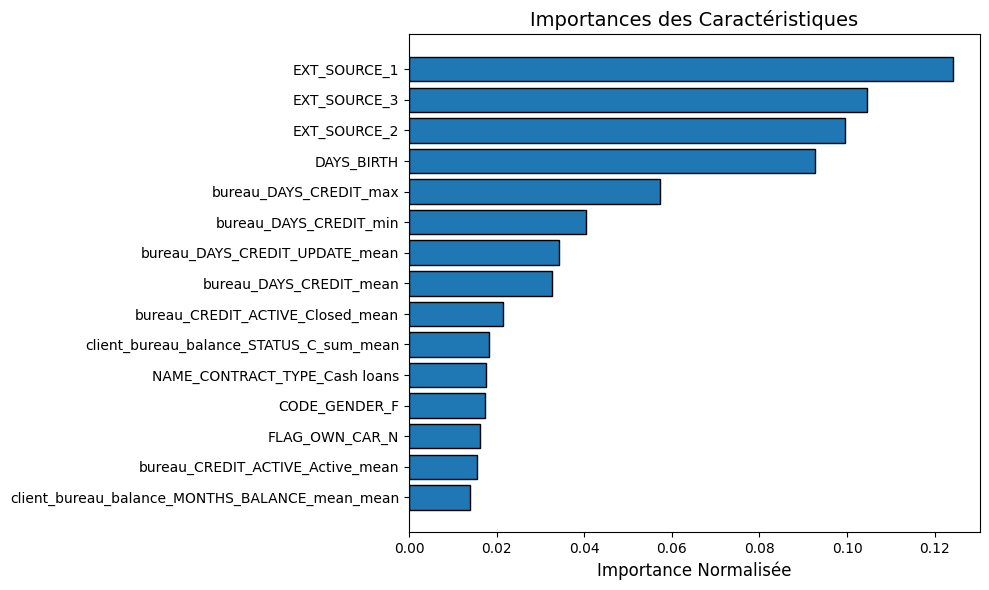

In [ ]:
feat_importances = plot_feature_importances(fi)

D'après le feature importances, nous avons **15 importantes caractéristiques**

In [ ]:
# pickle.dump(data, open(CHEMIN_PICKLE+'DATA', 'wb')) #
# d2 = pickle.load(open(CHEMIN_PICKLE+'DATA', 'rb'))

In [ ]:
fi.sort_values('importance', ascending = False).head(15)['feature'].unique()

**Les variables issues des données des autres organismes de prêt de crédit** du client. Elles résument les interactions passées avec des institutions financières.

 - ***bureau_DAYS_CREDIT_max*** : Nombre de jours depuis le crédit le plus ancien enregistré dans les données d'une institution financière. Elle reflète l'historique de crédit d'un client (un crédit ancien peut indiquer une expérience plus longue dans la gestion des emprunts, souvent associée à un risque moindre).

 - ***bureau_DAYS_CREDIT_min*** : Nombre de jours depuis le crédit le plus récent enregistré dans les données du bureau.
Cela donne une idée de l'activité récente du client en termes de crédit. Une activité récente peut indiquer un besoin urgent de liquidités, ce qui peut être un signal de risque.

 - ***bureau_DAYS_CREDIT_UPDATE_mean*** : Moyenne du nombre de jours depuis la dernière mise à jour des crédits enregistrés pour le client.
Utilité : Cela mesure la fréquence des interactions ou des mises à jour concernant les crédits du client. Des mises à jour fréquentes peuvent être un indicateur d'un client actif ou risqué.

 - ***bureau_DAYS_CREDIT_mean*** : Moyenne du nombre de jours depuis l'ouverture des crédits enregistrés dans les données du bureau. Elle noius résume l'activité de crédit globale d'un client, avec des crédits anciens pouvant être associés à une expérience de crédit plus longue.

 - ***bureau_CREDIT_ACTIVE_Closed_mean*** : Moyenne du statut des crédits "fermés" parmi tous les crédits enregistrés dans le bureau.
Utilité : Une proportion élevée de crédits fermés peut indiquer que le client a bien géré ses crédits dans le passé.

 - ***bureau_CREDIT_ACTIVE_Active_mean*** : Moyenne du statut des crédits "actifs" parmi tous les crédits enregistrés dans le bureau. Une proportion élevée de crédits actifs peut indiquer un client actuellement très engagé financièrement, ce qui pourrait représenter un risque accru.

**Les vraiables de "bureau_balance" suivent les historiques mensuels des crédits d'un client dans d'autres institutions financières.**

 - ***client_bureau_balance_STATUS_C_sum_mean*** : Moyenne du nombre de mois où le statut d'un crédit était "C" ("complètement payé"). Elle permet de suivre les performances passées du client dans le remboursement de ses crédits.

 - ***client_bureau_balance_MONTHS_BALANCE_mean_mean***: Moyenne des soldes mensuels des crédits du bureau (à travers tous les crédits). Cela peut donner une idée des montants restants à rembourser sur les crédits d'un client.


**Variables du feature engineering**

 - ***NAME_CONTRACT_TYPE_Cash loans*** : Variable binaire indiquant si le type de contrat du prêt est un "Cash loan" (prêt en espèces). Les prêts en espèces sont souvent considérés comme plus risqués que d'autres types de prêts (par exemple, prêts hypothécaires).

 - ***CODE_GENDER_F*** : Variable binaire indiquant si le client est une femme. Certaines analyses montrent que le genre peut avoir une corrélation avec les comportements de remboursement.

 - ***FLAG_OWN_CAR_N*** : Variable binaire indiquant si le client ne possède pas de voiture. La possession d'une voiture peut être un indicateur indirect de la situation financière ou de la stabilité d'un client.

*Application sur les tables avec les variables de base*

In [ ]:
submission_corrs, fi_corrs, metrics_corr = model(app_train, app_test)

Taille des données d'entraînement :  (307511, 238)
Taille des données de test :  (48744, 238)
[LightGBM] [Info] Number of positive: 19919, number of negative: 226089
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11471
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 231
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798747	train's binary_logloss: 0.547677	valid's auc: 0.754529	valid's binary_logloss: 0.563484
[400]	train's auc: 0.828674	train's binary_logloss: 0.517871	valid's auc: 0.754646	valid's binary_logloss: 0.545322
Early stopping, best iteration is:
[331]	train's a

In [ ]:
metrics_corr

,fold,train,valid
0,0,0.819446,0.755103
1,1,0.820247,0.758916
2,2,0.801689,0.762993
3,3,0.804044,0.758421
4,4,0.822604,0.758829
5,overall,0.813606,0.758787


Nous avons un **score de 0.759**.

**Features importances**

In [ ]:
fi_corrs.sort_values('importance', ascending = False).head(15)['feature'].nunique()

15

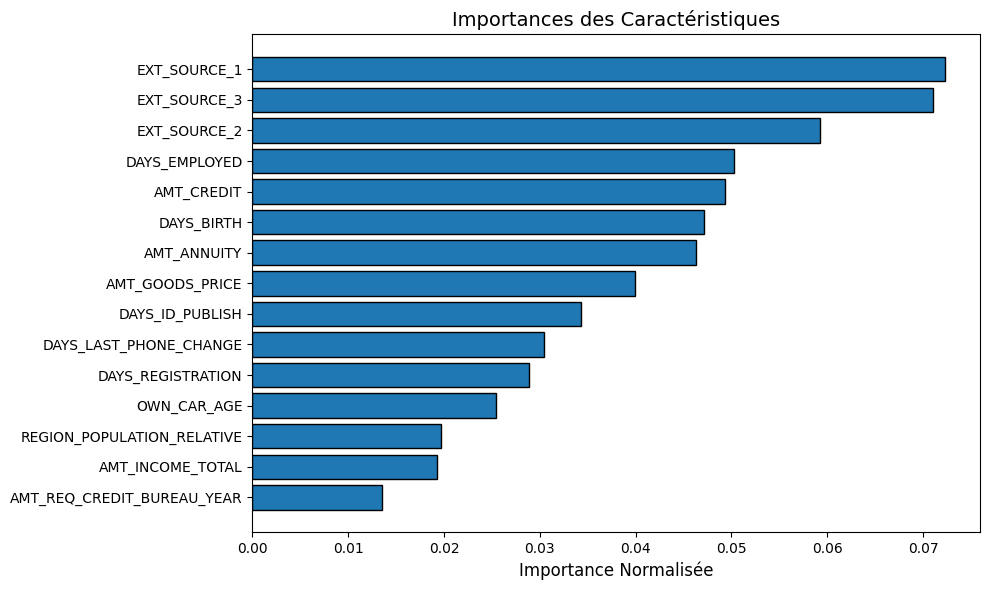

In [ ]:
feat_importances_corr = plot_feature_importances(fi_corrs)